In [69]:
import os
import pandas as pd
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir("/home/sophie/projects/windspeed/bin/") # change to directory where the module is. Must be a better way?
from p3group_tseries import read_file # Why is it not nec

WSa=['61223Tombouctou','61226Gao','61230NioroDuSahel','61498Kiffa',
'61499AiounElAtrouss','61492Kaedi','61497Nema','61450Tidjika']

CSal=['61024Agadez','61045Goure','61052Niamey','64753Faya',
'61017Bilma']

fname = CSal[3]

In [70]:
column_names=["year","month","day","hour","ws"]
dtype={"year":int,"month":int,"day":int,"hour":int,"ws":float}

datafile='/home/sophie/projects/windspeed/data/%s_allwinds.txt' %fname

# specify the columns you want to group together. Can't include hour at 
# this point as it is not in the right format. 
date_spec = {'date_time': [0,1,2]}

# when you use keep_dat_col it keeps them as objects, not as the dtype you 
# read them in as.
wind = pd.read_csv(datafile, sep=" ", names=column_names, 
parse_dates=date_spec,   keep_date_col=True, index_col=False ) 

# Dealing with hour - going from 600, 1200 etc to 6,12, 18
wind["hour"]=(wind["hour"]/100).astype(int)

In [71]:
print (list(wind))
print(wind['date_time'][0:10])
wind['new_date'] = pd.to_datetime(wind.date_time) + wind.hour.astype('timedelta64[h]')
print(wind['new_date'][0:10])
# could just join them? 

['date_time', 'year', 'month', 'day', 'hour', 'ws']
0   1987-06-21
1   1987-06-22
2   1987-06-25
3   1987-06-26
4   1987-06-27
5   1987-06-29
6   1987-06-30
7   1987-07-01
8   1987-07-02
9   1987-07-03
Name: date_time, dtype: datetime64[ns]
0   1987-06-21 12:00:00
1   1987-06-22 06:00:00
2   1987-06-25 12:00:00
3   1987-06-26 12:00:00
4   1987-06-27 12:00:00
5   1987-06-29 12:00:00
6   1987-06-30 06:00:00
7   1987-07-01 06:00:00
8   1987-07-02 06:00:00
9   1987-07-03 06:00:00
Name: new_date, dtype: datetime64[ns]


In [72]:
# combining year, month, day that were parsed together into date_time with 
# hour, which is now in the correct format.
wind['date_time'] = pd.to_datetime(wind.date_time) + \
wind.hour.astype('timedelta64[h]')

# make datetime the index before making subsections.
wind.index = wind['date_time']  

# drop any date time duplicates
wind.drop_duplicates(['date_time'],inplace=True)

In [73]:
def meanf(x):
    if x.count() > 10:
        return x.mean()
	
def sdf(x):
    if x.count() > 10:
        return x.std()
# Adds extra rows where value is kept if it meets isin() criteria. Nan if 
# it doesn't.
wind['ws_0']= wind['ws'][wind['hour'].isin([0])]
wind['ws_06']= wind['ws'][wind['hour'].isin([6])]
wind['ws_12']= wind['ws'][wind['hour'].isin([12])]
wind['ws_18']= wind['ws'][wind['hour'].isin([18])]

group = wind.groupby(['year', 'month'])

#Using the defined functions above
wind_group = group['ws','ws_0','ws_06','ws_12','ws_18'].agg([meanf,sdf])

In [74]:
 wind_group = read_file('61497Nema')

In [75]:
# reset the multiIndex

##No looping this time - changed the groupby object into a dataFrame and there is no MultiIndex there now.
df = wind_group.reset_index()

#df['date_time'] = pd.to_datetime((df.year) + (df.month))
#df['date_time'] = timestamp(df.year.astype('timedelta64[h]')+df.month.astype('timedelta64[h]')+0)
#df['date']= df.apply(lambda x:datetime.strptime("{0} {1} {2}".format(x['year'],x['month'], x['day']), "%Y %m %d"),axis=1)
#df['DateTime'] = df.apply(lambda x : datetime(x.year,x.month,0),axis = 1)
p = pd.to_datetime('1984/4')
print (p)

1984-04-01 00:00:00


## Here is the Solution:

In [76]:
# Join the year and month columns, then apply pd.to_datetime line by line!
df['date_time'] = df[['year', 'month']].apply(lambda x: pd.to_datetime('/'.join(x)), axis=1)

print (list(df))

[('year', ''), ('month', ''), ('ws', 'meanf'), ('ws', 'sdf'), ('ws_0', 'meanf'), ('ws_0', 'sdf'), ('ws_06', 'meanf'), ('ws_06', 'sdf'), ('ws_12', 'meanf'), ('ws_12', 'sdf'), ('ws_18', 'meanf'), ('ws_18', 'sdf'), ('date_time', '')]


In [77]:
# make the date_time column the index
df.index = df['date_time']

print (df[0:10])

            year month        ws            ws_0         ws_06            \
                           meanf       sdf meanf sdf     meanf       sdf   
date_time                                                                  
1984-10-01  1984    10  4.151677  1.987521   NaN NaN  4.455082  1.662186   
1984-11-01  1984    11  4.220307  1.467515   NaN NaN  4.736873  1.042111   
1984-12-01  1984    12  5.047632  1.239740   NaN NaN  4.990743  0.805792   
1984-03-01  1984     3  5.047755  1.528767   NaN NaN  5.032444  0.951259   
1984-04-01  1984     4  4.288570  1.555165   NaN NaN  4.380465  1.066342   
1984-05-01  1984     5  4.905733  1.915265   NaN NaN  4.482214  1.714301   
1984-06-01  1984     6  4.658315  1.904019   NaN NaN  4.833093  1.523579   
1984-07-01  1984     7  4.279034  1.811648   NaN NaN  4.962407  1.428651   
1984-08-01  1984     8  4.081824  1.206366   NaN NaN  4.140754  1.007074   
1984-09-01  1984     9  3.842724  1.672004   NaN NaN  3.962058  1.182414   

           

date_time
2000-01-01    5.310023
2000-10-01    3.860523
2000-11-01    4.679905
2000-12-01    4.481158
2000-02-01    5.879926
2000-03-01    4.992868
2000-04-01    4.884327
2000-05-01    3.839838
2000-06-01    4.830786
2000-07-01    4.745874
2000-08-01    3.724661
2000-09-01    3.785110
2001-01-01    4.773573
2001-10-01    3.656597
2001-11-01    4.369995
2001-12-01    5.116658
2001-02-01    5.228244
2001-03-01    4.572235
2001-04-01    5.010381
2001-05-01    4.555336
2001-06-01    4.903203
2001-07-01    4.459743
2001-08-01    4.205406
2001-09-01    3.265250
Name: meanf, dtype: float64


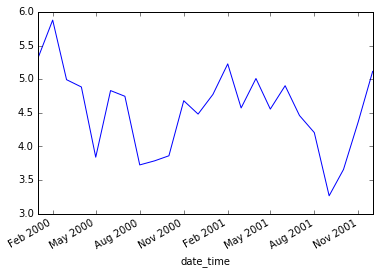

In [83]:
#df.plot(x = 'date_time', y = df.ws_06.meanf['1990':'1994'],figsize=(8,8),c='m')

#df.plot(df['2000':'2001'], df.ws_06['meanf'])

#df = df.reset_index
#df.index = df['date_index']

print (df['2000':'2001']['ws_06']['meanf'])

df.ws_06['meanf']['2000':'2001'].plot()

61223Tombouctou
61226Gao
61230NioroDuSahel
61498Kiffa
61499AiounElAtrouss
61492Kaedi
61497Nema
61450Tidjika


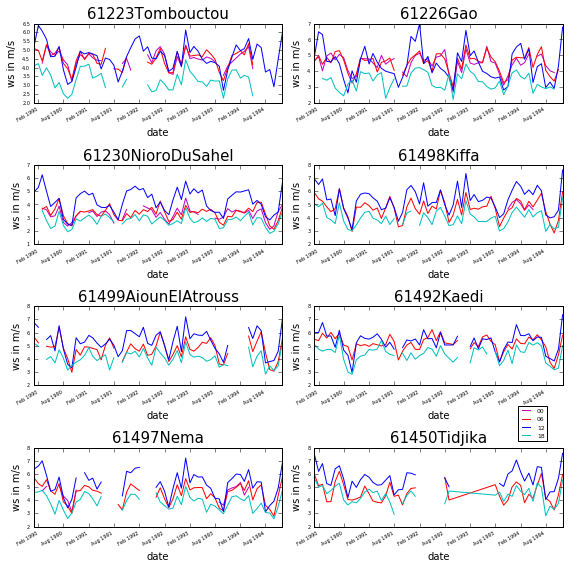

In [111]:
group = WSa

fig = plt.figure(figsize=(10,10))

for i in range(len(group)):

    # just for testing, see what group we are on
    print(group[i])

    # read in one station from the group, read_file will create a group by 
    # object ready for plotting 
    wind_group = read_file(group[i])
   
    # turn the multiIndex into a datetime index
    wind_group = wind_group.reset_index()
    
    wind_group['date'] = wind_group[['year', 'month']].apply(lambda x: pd.to_datetime('/'.join(x)), axis=1)
    
    wind_group.index=wind_group['date']
    
    #df = wind_group
    
    #print (wind_group['2000':'2001']['ws_06']['meanf'][0:10])
    if len(wind_group['1990':'1994']) != 0:
    # Dump the month part of the index to make the xaxis less crowded     
        #wind_group.index = wind_group.index.droplevel(['month']) # lets try plotting with new datetime index

    # fig.add_subplot(nrows, ncols, num)

        ax = fig.add_subplot(int((len(group)+1)/2), 2, i+1)

        plt.title(s=group[i], fontsize=15)
        
        plt.ylabel('ws in m/s')
        
        #fig.autofmt_xdate(bottom=0.2, rotation=20, ha='right')
        #fig.autofmt_xdate(rotation=20, ha='right')

    # May not need the if statements if I can solve the x problem below.
    # No, I do, so if there are no data in that time period it will be 
    # caught - as in Ouargla!
    #print(len(wind_group.ws_0['meanf']))  

        wind_group.ws_0['meanf']['1990':'1994'].plot(figsize=(8,8),c='m', fontsize = 5)    
        wind_group.ws_06['meanf']['1990':'1994'].plot(figsize=(8,8), c='r', fontsize = 5)  
        wind_group.ws_12['meanf']['1990':'1994'].plot(figsize=(8,8),c='b', fontsize = 5)   
        wind_group.ws_18['meanf']['1990':'1994'].plot(figsize=(8,8), c='c', fontsize = 5)
        
ax.legend(loc=4,bbox_to_anchor=(0.95, 1.05),labels 
= ['00','06','12','18'],prop={'size':6})

plt.tight_layout() # very nice! stops the titles overlapping
#fig.suptitle(group_strings[j])